# DIGLM Tutorial

In this notebook we illustrate with a toy model the usage of the DIGLM class. 

The notebook is organized as follows:

1. Introduction;
2. Creation of a toy dataset;
3. Building the model and defining training functons;
4. Support function for plotting and sampling;
5. Training;
6. Results and final considerations


## 1.  Introduction

An object of the DIGLM class is a trainable model which allows to accomplish the two following tasks:

1. Reproduce the feature distribution thanks to a *normalizing flow* step mapping the features to a latent space with multivariate normal distribution features;
2. Perform regression (linear, logistic and much more) with a Generalized Linear Model (GLM).

The idea comes from the article by [E. Nalisnick et al.](https://arxiv.org/abs/1902.02767) where the DIGLM model and algorithm characteristics is described and test on some examples are provided.

The two parts that constitute the algorithm are trained in a single feed-forward step of a semi-supervised training:
given the features observation $ \{x\}_i ^N $ and their true labels $ \{y\}_i ^N $, the loss function minimized is

$- \sum_i \log{p(y|x; \theta, \beta)} + \lambda \log{p(x; \theta)}$

where:

1. $\beta$ are the weights of the glm;
2. $\theta$ are the parameters that maps the distibution of $x$ to the space of the latent variables $z$ through the *normalizing flow*. The distribution of $z$ is set to be a multivariate normal distribution with dimension equal to the space of the feature vectors;
3. $\lambda$ is a hyper-parameter which weights the importance in the training of the two different parts of the loss: the first term indeed is used to solve the regression problem; the second one trains the *normalizing flow*. 




In [1]:
! git clone https://github.com/MarcoRiggirello/diglm.git

import sys
sys.path.append('diglm/src')
import os
import logging

import tensorflow as tf
from tensorflow import Variable, ones, zeros
from tensorflow_probability import glm
from tensorflow_probability import distributions as tfd
from tensorflow.keras import metrics
import numpy as np
import seaborn as sns
import sklearn.datasets as skd # where we can find a simple example
import matplotlib.pyplot as plt
import pandas as pd

from diglm import Diglm
from spqr import NeuralSplineFlow as NSF


# sinlencing tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Cloning into 'diglm'...
remote: Enumerating objects: 800, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 800 (delta 157), reused 143 (delta 138), pack-reused 608
Receiving objects: 100% (800/800), 5.59 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (464/464), done.


## 2. Toy dataset

The feature vectors $x_1$ and $x_2$ are sampled from a uniform distribution $U[-1, 1]$.
The response function $y(x_1, x_2): \mathbb{R}^2 \rightarrow \{0, 1\}$ is:
$
\begin{cases}
1 \text{ if } x_1 \cdot x_2 > \dfrac{1}{x_1 \cdot x_2} \\
0 \text{ elsewise} \\
\end{cases}
$

The sampled vectors and the response are transformed to a `tf.data.Dataset`.

Text(0.5, 1.05, 'Target distribution')

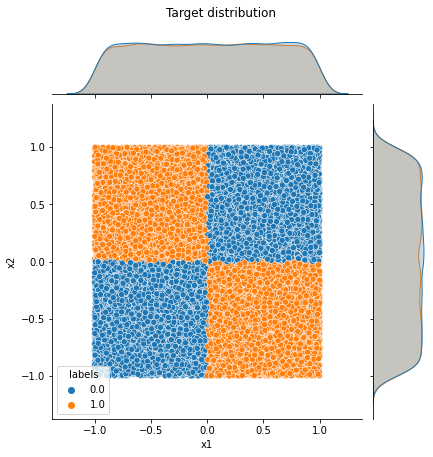

In [2]:
#response function
response = lambda x1, x2: x1 * x2 > 1 / (x1 * x2) 

BATCH_SIZE = 1024
DATASET_SIZE = BATCH_SIZE * 32
VAL_SIZE = BATCH_SIZE * 16

# dataset for training
X1 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
X2 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
df = pd.DataFrame(np.stack((response(X1, X2), X1, X2), axis=1),
                  columns=['labels','x1', 'x2'])

# dataset for validation
X1_val = np.random.uniform(low=-1, high=1, size=VAL_SIZE)
X2_val = np.random.uniform(low=-1, high=1, size=VAL_SIZE) 
df_val = pd.DataFrame(np.stack((response(X1_val, X2_val), X1_val, X2_val), axis=1),
                  columns=['labels','x1', 'x2'])

# dataset for test
X1_test = np.random.uniform(low=-1, high=1, size=VAL_SIZE)
X2_test = np.random.uniform(low=-1, high=1, size=VAL_SIZE) 
df_test = pd.DataFrame(np.stack((response(X1_test, X2_test), X1_test, X2_test), axis=1),
                  columns=['labels','x1', 'x2'])

# plotting the toy dataset with marginalized feature distribution too
joint_plot = sns.jointplot(data=df, x='x1', y='x2', hue='labels')
joint_plot.figure.suptitle('Target distribution', y = 1.05)

(512, 2) (512,)
(512,)


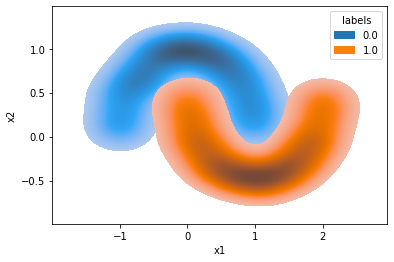

In [17]:
BATCH_SIZE = 256
DATASET_SIZE = BATCH_SIZE * 2
SAMPLE_SIZE = DATASET_SIZE

# load the dataset
moons_ft, moons_l = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)
print(moons_ft.shape, moons_l.shape)

moons_ft1, moons_ft2 = np.squeeze(np.split(moons_ft, 2, axis=1))
print(moons_ft1.shape)

# transform the dataset to a `tf.data.Dataset` object for autobatching,
# multiprocessing, speed up etc... 


df = pd.DataFrame(np.stack((moons_l, moons_ft1, moons_ft2), axis=1), columns=['labels', 'x1', 'x2'])

moons_ds = tf.data.Dataset.from_tensor_slices(df.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.batch(BATCH_SIZE)

# let's visualize the moons dataset. which our algorithm will
# hopefully learn to reproduce
sns.kdeplot(data=df, x='x1', y='x2', hue='labels',
            fill=True, levels=100)

## 3. Utilities: transforming datasets, sampling of distributions and plotting

We define some functions to transform our data into TesnorFlow datasets for automatic batching and parallelization; to extract sample from the transformed distributions and to plot them.

In [18]:
def to_tf_dataset(df, columns, dtype='float32', batch_size=32):
    """
    util function to transform a pandas.DataFrame into a
    batched tf.data.Dataset.
    
    """

    tf_ds = tf.data.Dataset.from_tensor_slices(df[columns].astype(dtype))
    tf_ds = tf_ds.prefetch(tf.data.experimental.AUTOTUNE)
    tf_ds = tf_ds.cache()
    tf_ds = tf_ds.batch(batch_size)
    return tf_ds

def sampling(size=500):
    """
    returns a sample of the transformed disribution and its computed
    response through glm evaluation.

    """
    trans_sample = diglm.sample(size)['features']
    mean_sample, var_sample, grad_sample  = diglm(trans_sample)
    x1, x2 = np.split(trans_sample.numpy(), 2, axis=1)
    x1 = np.concatenate(x1)
    x2 = np.concatenate(x2)
    mean = np.concatenate(mean_sample.numpy().T)
    return mean, x1, x2

def plot(name, counter=None): 
    """
    plotting function that gets some samples from the norm. flow
    inverse distribution and the calculated response and plots it
    alongside with the target distribution
    """
    # Get sampling data to plot
    mean, x1, x2 = sampling(size=VAL_SIZE)
    df_train = pd.DataFrame(np.stack((mean, x1, x2), axis=1),
                            columns=['labels', 'x1', 'x2'])
    #plot
    #fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # training data samples
    ax_1 = sns.scatterplot(data=df_train, x='x1', y='x2', hue='labels', palette='coolwarm')
    #sns.histplot(data=df, x='x1', y='x2', hue='labels', alpha=0.5, ax=ax_1)
    # target distribution
    #sns.scatterplot(data=df, x='x1', y='x2', hue='labels', ax=ax_2)
    ax_1.set_ylim(min(x1), max(x1))
    ax_1.set_xlim(min(x1), max(x2))
    if counter is not None: # used to track the training epoch
        ax_1.set_title(f'Training epoch = {counter}')
    #ax_2.set_title('Target distribution')

    plt.savefig(name) 

train_ft = to_tf_dataset(df, ['x1', 'x2'], batch_size=BATCH_SIZE)
train_l = to_tf_dataset(df, ['labels'], dtype='int32', batch_size=BATCH_SIZE)

val_ft = to_tf_dataset(df_val, ['x1', 'x2'], batch_size=VAL_SIZE)
val_l = to_tf_dataset(df_val, ['labels'], dtype='int32', batch_size=VAL_SIZE)

test_ft = to_tf_dataset(df_test, ['x1', 'x2'], batch_size=VAL_SIZE)
test_l = to_tf_dataset(df_test, ['labels'], dtype='int32', batch_size=VAL_SIZE)


## 4. Building the DIGLM 

We initialize our diglm model with:

1. a NeuralSplineFlow object as bijector with two splits (there are only two variables
2. a `tf.glm.Bernoulli()` as glm to realize the logistic regression.


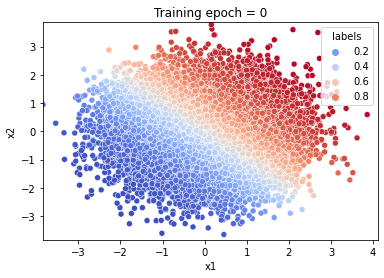

In [19]:
my_glm = glm.Bernoulli()
neural_spline_flow = NSF(splits=2, spline_params=dict())
diglm = Diglm(neural_spline_flow, my_glm, 2)

train_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(train_l, train_ft)]
val_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(val_l, val_ft)]
test_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(test_l, test_ft)]


# let's visualize a sample from the inverse distribution of the bijector
# before training.
plot('start.jpeg', counter=0)

## 5. Training

First, we define a train step, where the loss and its gradient are calculated and the training variables of the model are updated accordingly. We follow the [keras tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

In [23]:
@tf.function
def train_step(optimizer, target_sample, weight=.1):
    """
    Train step function for the diglm model. Implements the basic steps for computing
    and updating the trainable variables of the model. It also
    calculates the loss on training and validation samples.

    """

    with tf.GradientTape() as tape:
        # calculating loss and its gradient of training data
        loss = -tf.reduce_mean(diglm.weighted_log_prob(target_sample, scaling_const=weight))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

Now we are ready to train the model!

0.5918579


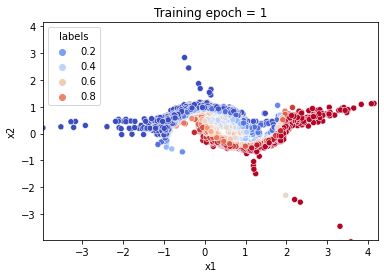

Epoch = 1 	 Loss = 0.000 	 Val loss = 0.000


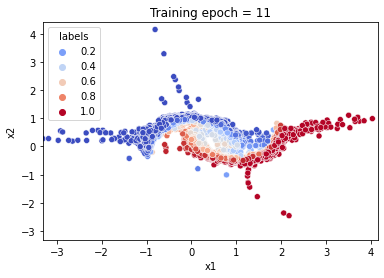

Epoch = 11 	 Loss = -11.994 	 Val loss = 578.476


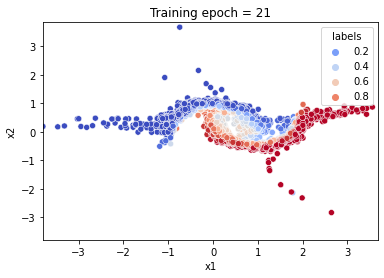

Epoch = 21 	 Loss = -29.492 	 Val loss = 604.204


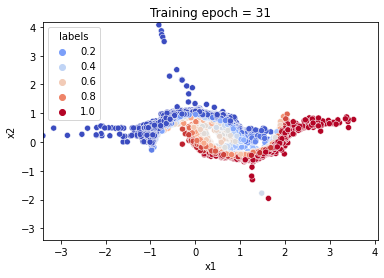

Epoch = 31 	 Loss = -38.895 	 Val loss = 617.316


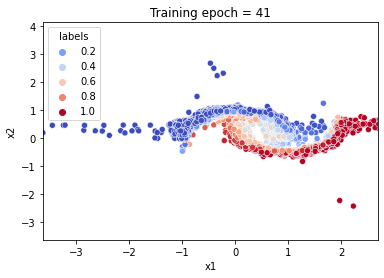

Epoch = 41 	 Loss = -44.160 	 Val loss = nan


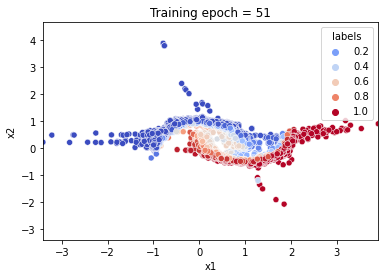

Epoch = 51 	 Loss = -45.343 	 Val loss = 635.307


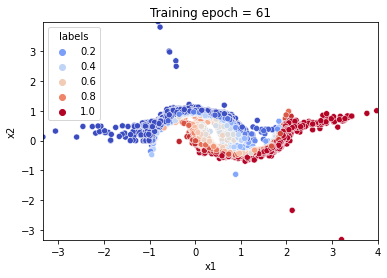

Epoch = 61 	 Loss = -49.389 	 Val loss = nan


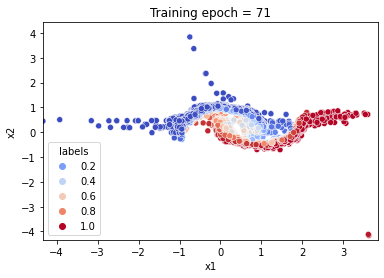

Epoch = 71 	 Loss = -51.027 	 Val loss = 639.017


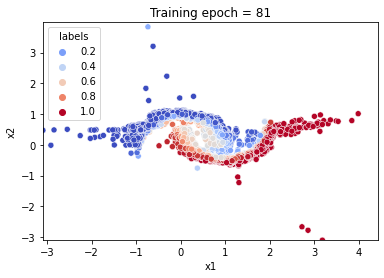

Epoch = 81 	 Loss = -54.243 	 Val loss = 651.394


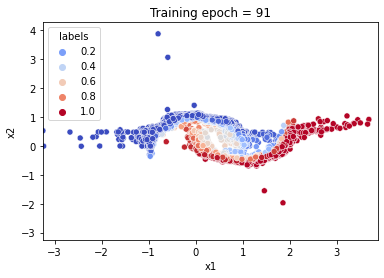

Epoch = 91 	 Loss = -59.094 	 Val loss = 658.178


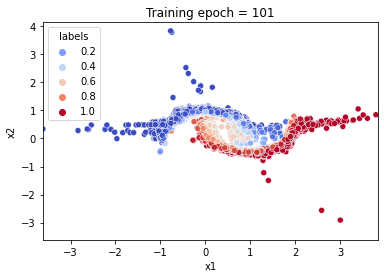

Epoch = 101 	 Loss = -63.894 	 Val loss = 661.566


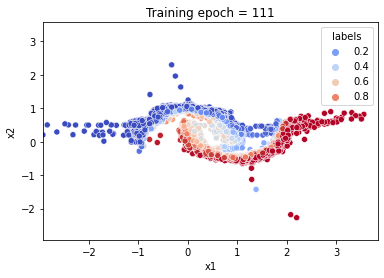

Epoch = 111 	 Loss = -56.863 	 Val loss = 662.627


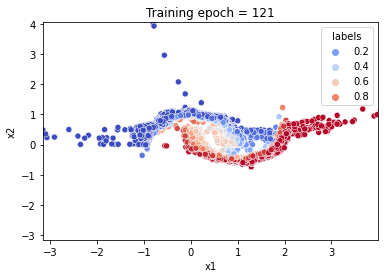

Epoch = 121 	 Loss = -55.962 	 Val loss = 673.238


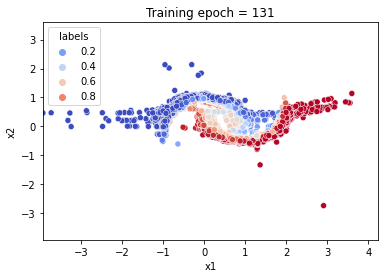

Epoch = 131 	 Loss = -51.319 	 Val loss = 660.000


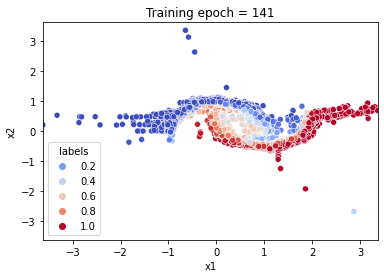

Epoch = 141 	 Loss = -54.815 	 Val loss = 671.327


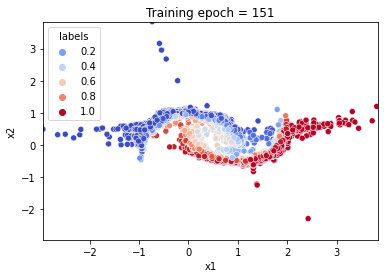

Epoch = 151 	 Loss = -59.380 	 Val loss = nan


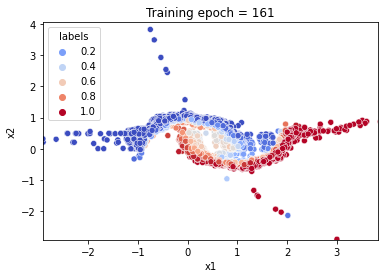

Epoch = 161 	 Loss = -61.843 	 Val loss = 666.841


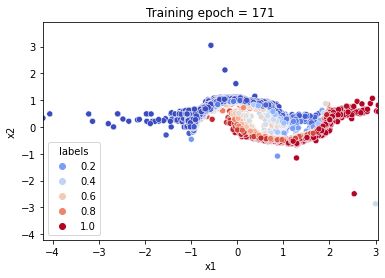

Epoch = 171 	 Loss = -56.417 	 Val loss = 666.414


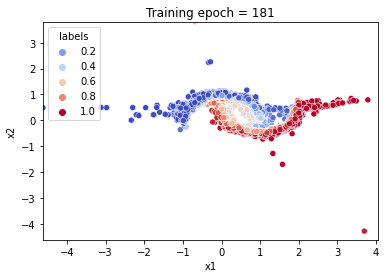

Epoch = 181 	 Loss = -68.998 	 Val loss = 682.753


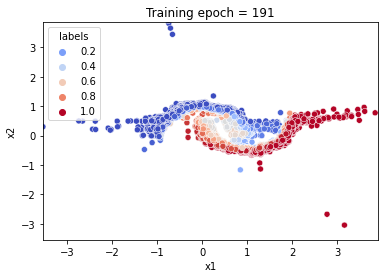

Epoch = 191 	 Loss = -68.709 	 Val loss = 684.981


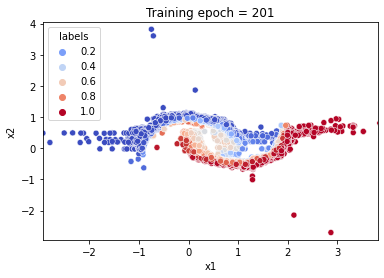

Epoch = 201 	 Loss = -61.851 	 Val loss = nan


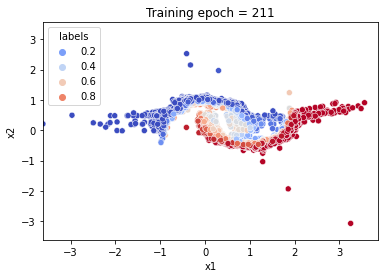

Epoch = 211 	 Loss = -65.174 	 Val loss = 686.313


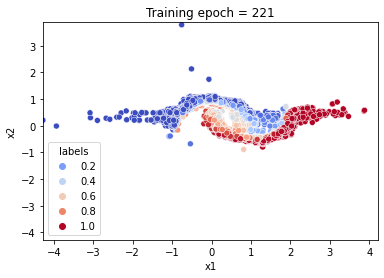

Epoch = 221 	 Loss = -21.487 	 Val loss = 695.778


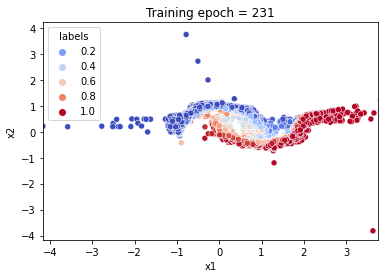

Epoch = 231 	 Loss = -27.772 	 Val loss = nan


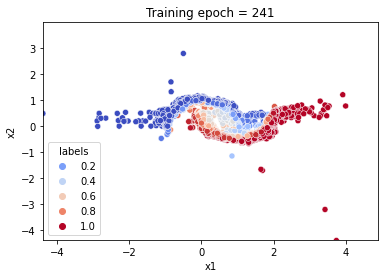

Epoch = 241 	 Loss = -46.209 	 Val loss = 683.976


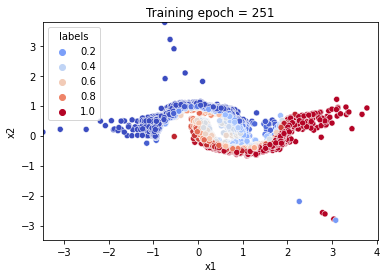

Epoch = 251 	 Loss = -64.136 	 Val loss = 680.064


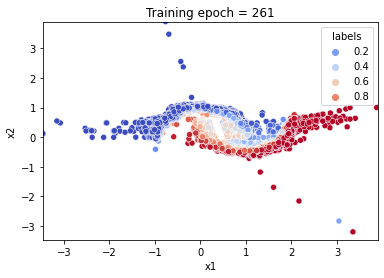

Epoch = 261 	 Loss = -63.801 	 Val loss = 688.739


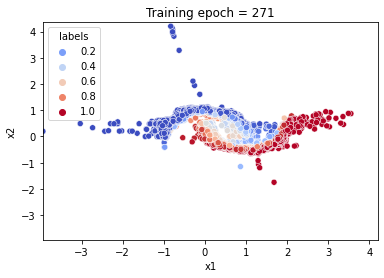

Epoch = 271 	 Loss = -73.771 	 Val loss = 693.470


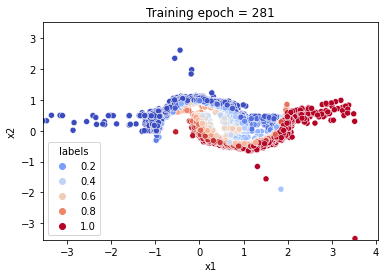

Epoch = 281 	 Loss = -55.866 	 Val loss = nan


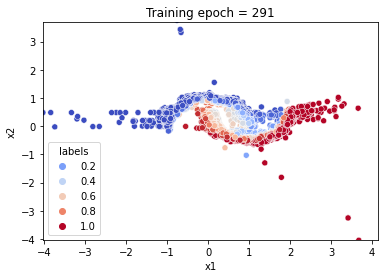

Epoch = 291 	 Loss = -63.658 	 Val loss = 706.736


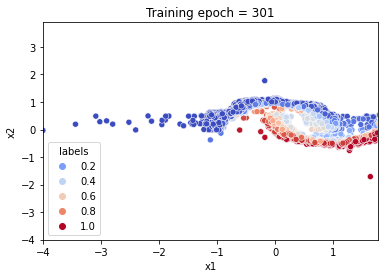

Epoch = 301 	 Loss = -65.604 	 Val loss = 699.771


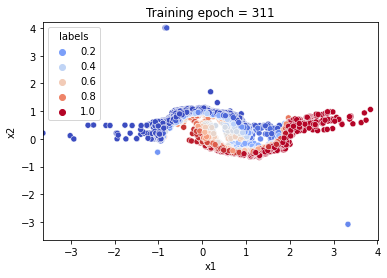

Epoch = 311 	 Loss = -64.854 	 Val loss = 710.107


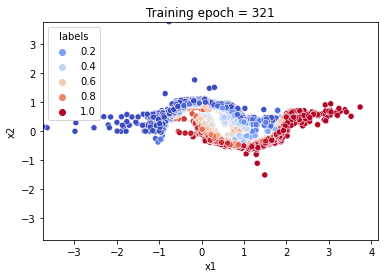

Epoch = 321 	 Loss = -52.198 	 Val loss = 697.857


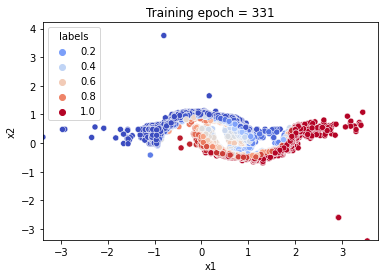

Epoch = 331 	 Loss = -53.907 	 Val loss = 704.307


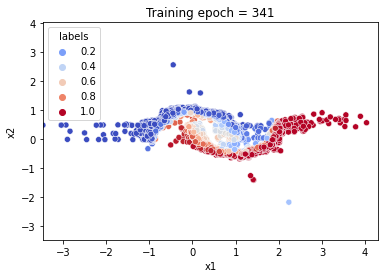

Epoch = 341 	 Loss = -65.455 	 Val loss = 694.734


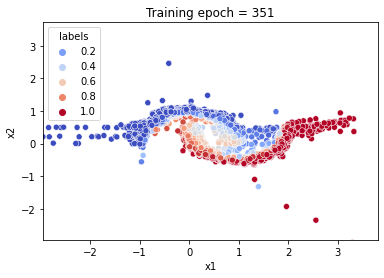

Epoch = 351 	 Loss = -78.049 	 Val loss = 702.646


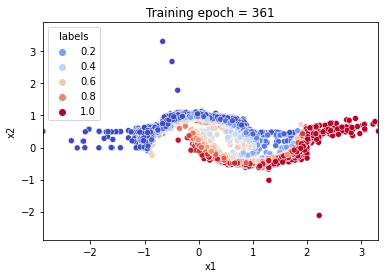

Epoch = 361 	 Loss = -78.078 	 Val loss = 701.620


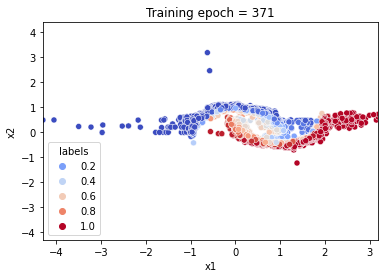

Epoch = 371 	 Loss = -77.328 	 Val loss = 712.029


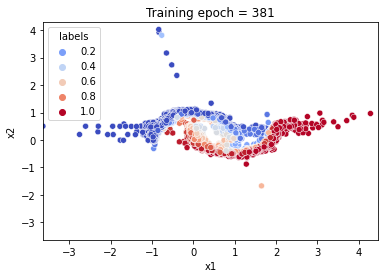

Epoch = 381 	 Loss = -45.431 	 Val loss = 700.129


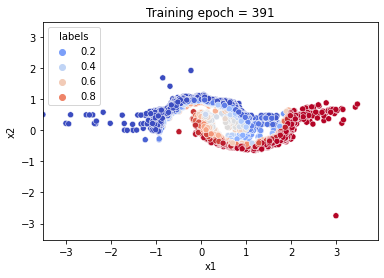

Epoch = 391 	 Loss = -15.263 	 Val loss = nan


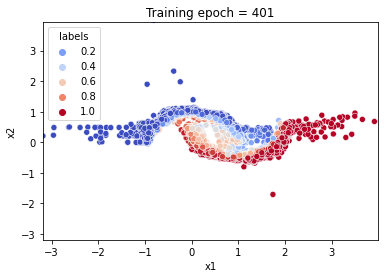

Epoch = 401 	 Loss = -40.826 	 Val loss = nan


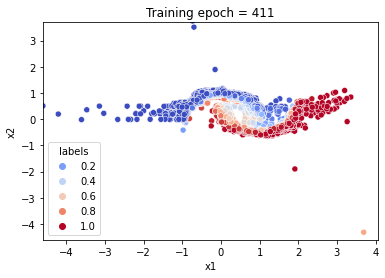

Epoch = 411 	 Loss = -56.665 	 Val loss = 694.351


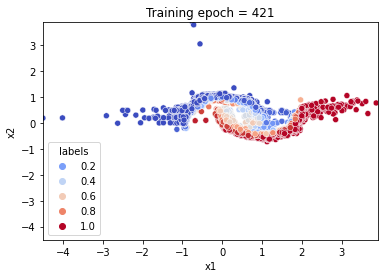

Epoch = 421 	 Loss = -44.276 	 Val loss = nan


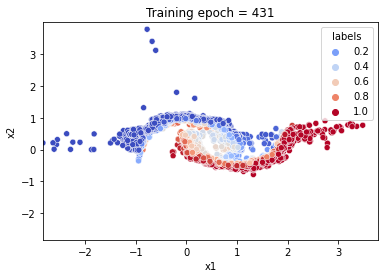

Epoch = 431 	 Loss = -58.188 	 Val loss = 696.518


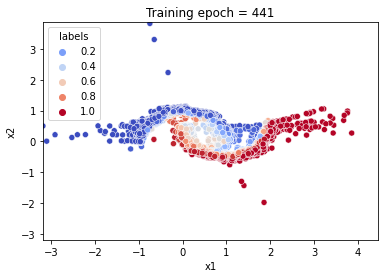

Epoch = 441 	 Loss = -38.080 	 Val loss = 696.125


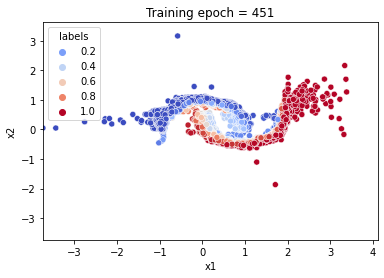

Epoch = 451 	 Loss = 44.143 	 Val loss = 678.893


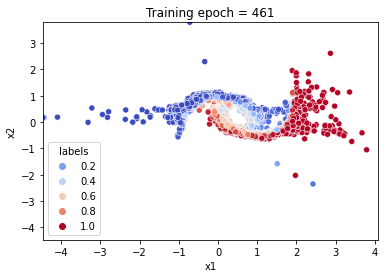

Epoch = 461 	 Loss = -27.152 	 Val loss = nan


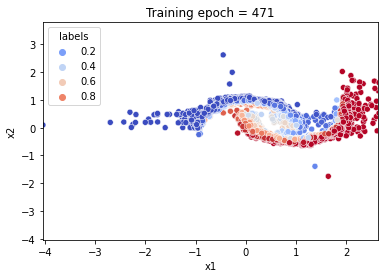

Epoch = 471 	 Loss = -42.833 	 Val loss = nan


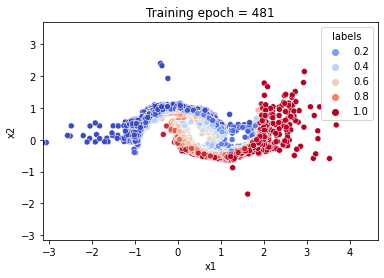

Epoch = 481 	 Loss = -4.568 	 Val loss = 682.203


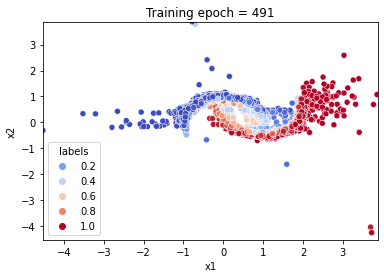

Epoch = 491 	 Loss = -25.121 	 Val loss = 686.632


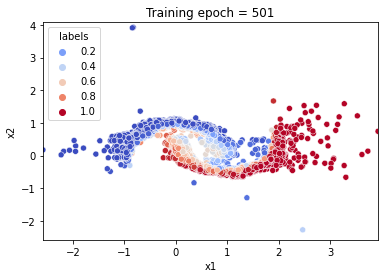

Epoch = 501 	 Loss = -46.074 	 Val loss = 670.457


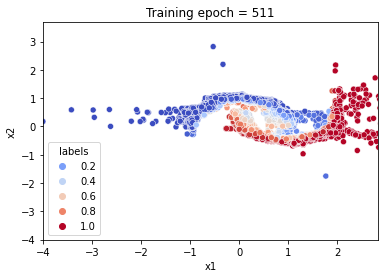

Epoch = 511 	 Loss = -54.586 	 Val loss = 685.269


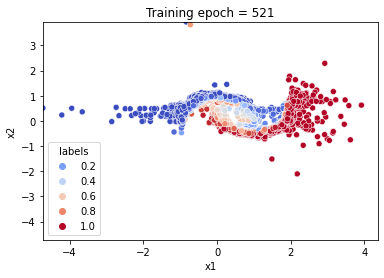

Epoch = 521 	 Loss = -68.522 	 Val loss = 695.531


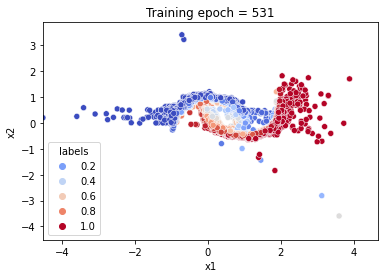

Epoch = 531 	 Loss = -71.787 	 Val loss = 692.797


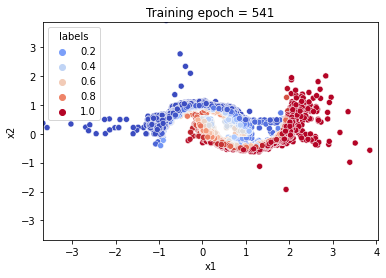

Epoch = 541 	 Loss = -79.714 	 Val loss = 699.354


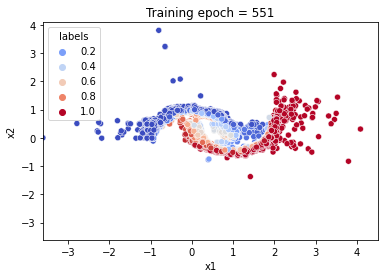

Epoch = 551 	 Loss = -81.251 	 Val loss = 709.345


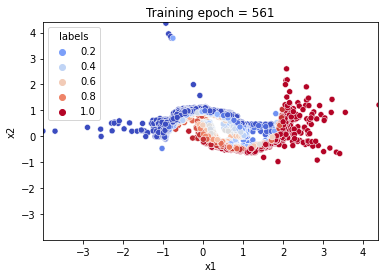

Epoch = 561 	 Loss = -68.260 	 Val loss = 709.625


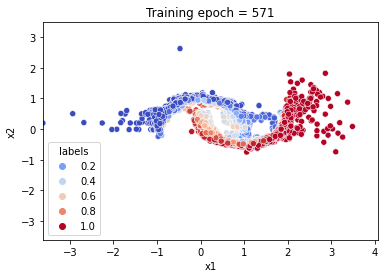

Epoch = 571 	 Loss = -63.429 	 Val loss = 720.717


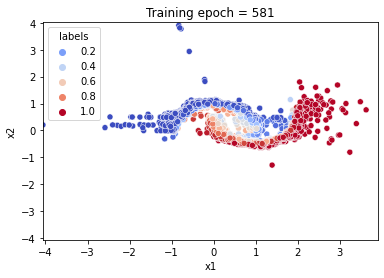

Epoch = 581 	 Loss = -83.962 	 Val loss = 718.759


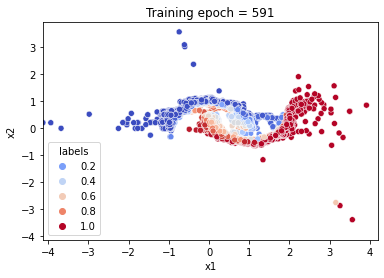

Epoch = 591 	 Loss = -77.266 	 Val loss = 714.718


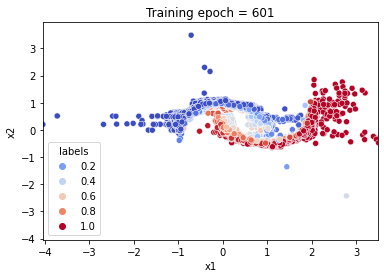

Epoch = 601 	 Loss = -55.038 	 Val loss = nan


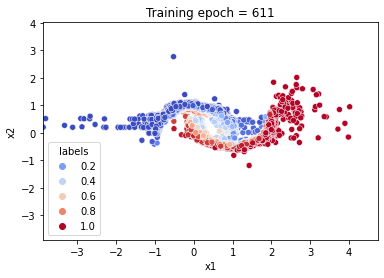

Epoch = 611 	 Loss = -72.468 	 Val loss = 690.922


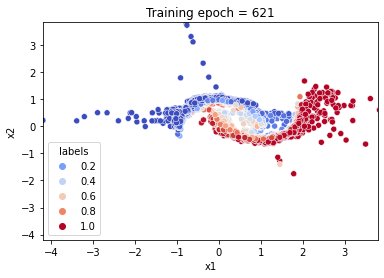

Epoch = 621 	 Loss = -82.368 	 Val loss = nan


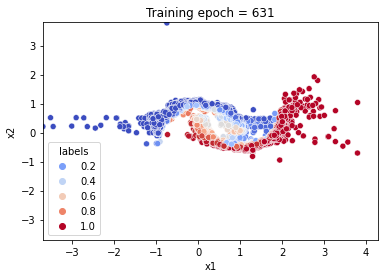

Epoch = 631 	 Loss = -88.080 	 Val loss = 718.051


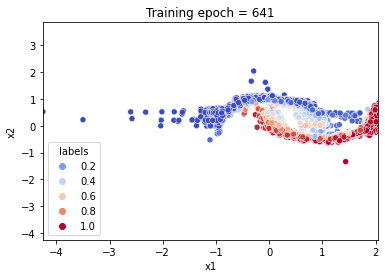

Epoch = 641 	 Loss = -76.673 	 Val loss = nan


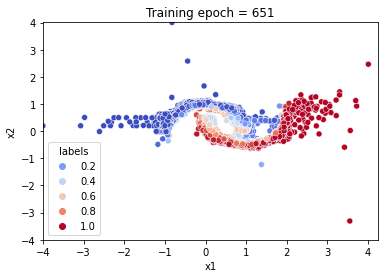

Epoch = 651 	 Loss = -92.032 	 Val loss = 717.396


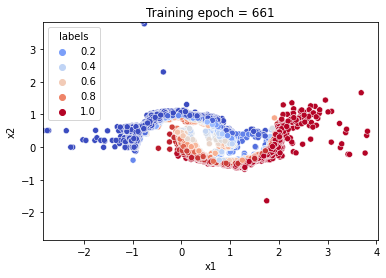

Epoch = 661 	 Loss = -76.976 	 Val loss = nan


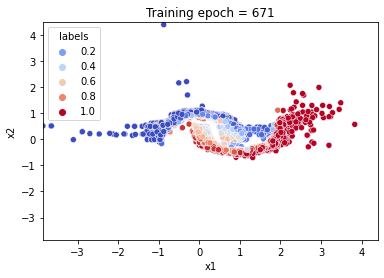

Epoch = 671 	 Loss = -68.475 	 Val loss = nan


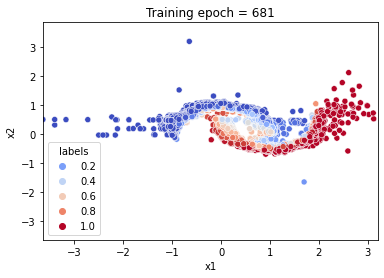

Epoch = 681 	 Loss = -83.387 	 Val loss = 705.250


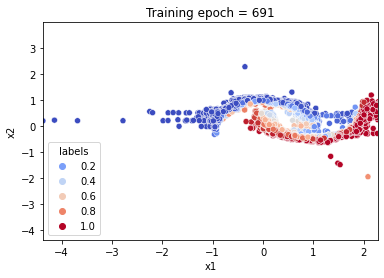

Epoch = 691 	 Loss = -96.016 	 Val loss = nan


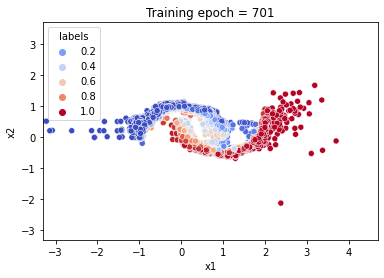

Epoch = 701 	 Loss = -92.613 	 Val loss = 712.352


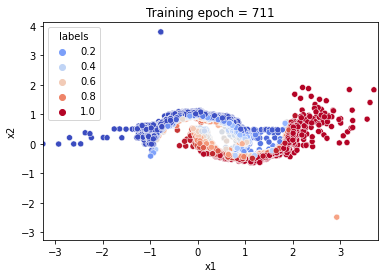

Epoch = 711 	 Loss = -88.579 	 Val loss = nan


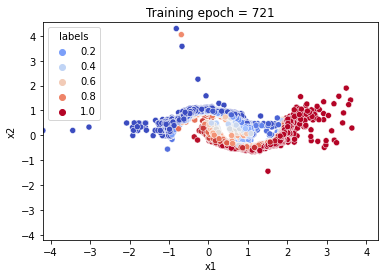

Epoch = 721 	 Loss = -74.965 	 Val loss = 712.736


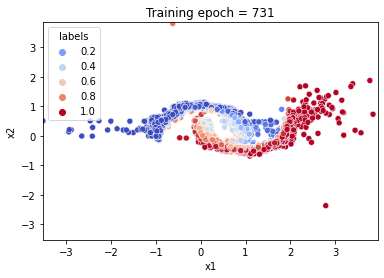

Epoch = 731 	 Loss = -43.810 	 Val loss = 712.509


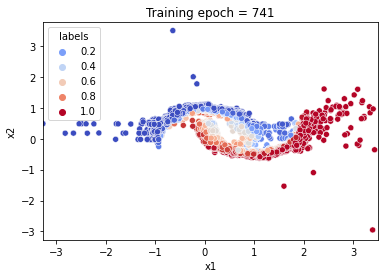

Epoch = 741 	 Loss = -45.274 	 Val loss = 701.854


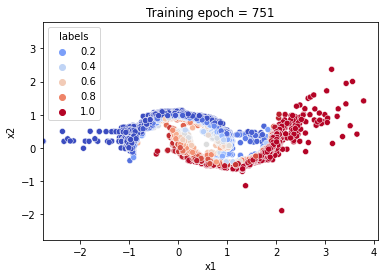

Epoch = 751 	 Loss = -79.716 	 Val loss = 705.876


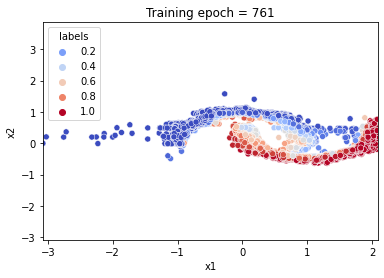

Epoch = 761 	 Loss = -85.491 	 Val loss = nan


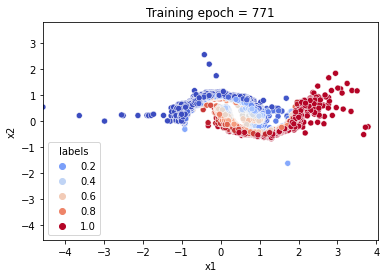

Epoch = 771 	 Loss = -87.942 	 Val loss = nan


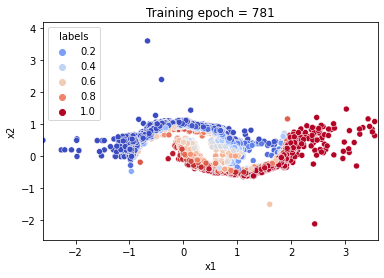

Epoch = 781 	 Loss = -78.382 	 Val loss = 716.040


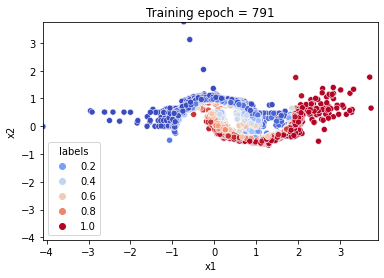

Epoch = 791 	 Loss = -94.523 	 Val loss = nan


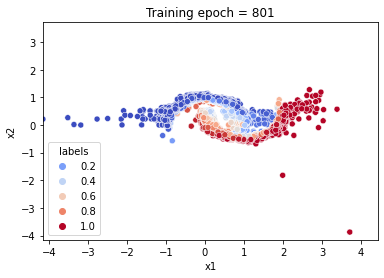

Epoch = 801 	 Loss = -88.845 	 Val loss = nan


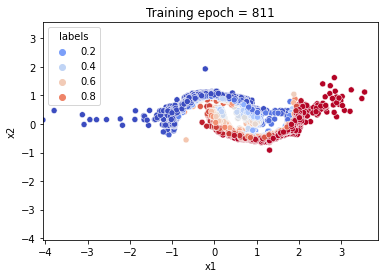

Epoch = 811 	 Loss = -56.562 	 Val loss = 697.884


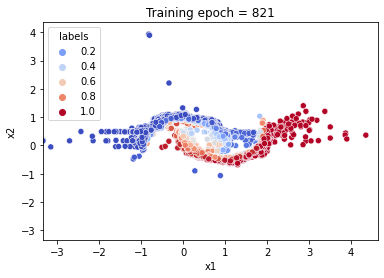

Epoch = 821 	 Loss = -64.886 	 Val loss = nan


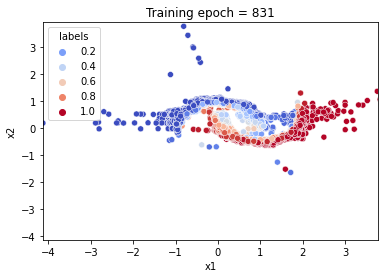

Epoch = 831 	 Loss = -78.184 	 Val loss = nan


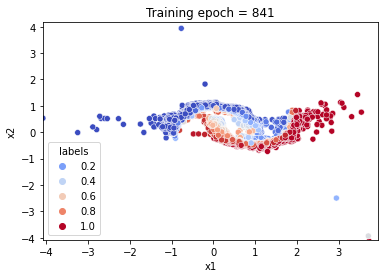

Epoch = 841 	 Loss = -81.329 	 Val loss = 705.768


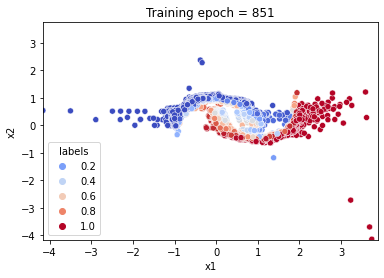

Epoch = 851 	 Loss = -72.512 	 Val loss = nan


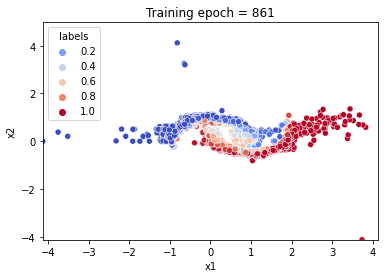

Epoch = 861 	 Loss = -92.851 	 Val loss = nan


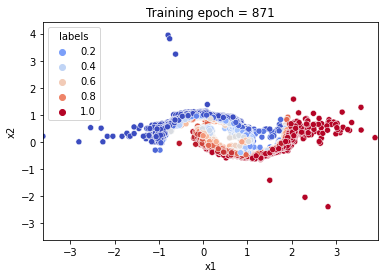

Epoch = 871 	 Loss = -96.057 	 Val loss = 713.096


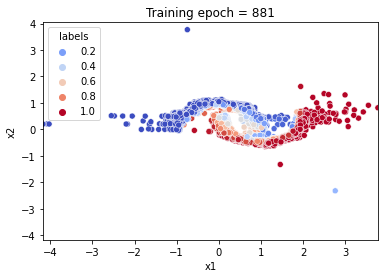

Epoch = 881 	 Loss = -106.867 	 Val loss = nan


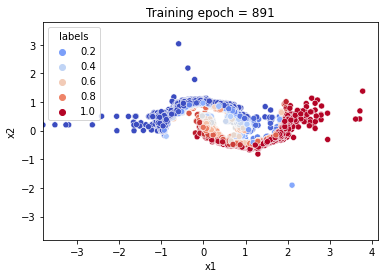

Epoch = 891 	 Loss = -101.482 	 Val loss = 722.152


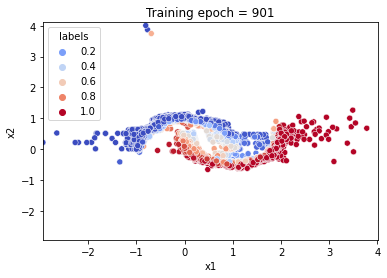

Epoch = 901 	 Loss = -85.408 	 Val loss = 726.085


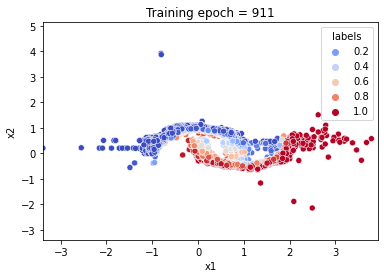

Epoch = 911 	 Loss = -83.769 	 Val loss = nan


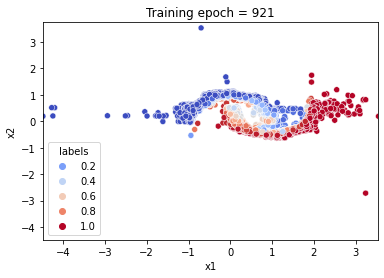

Epoch = 921 	 Loss = -79.059 	 Val loss = 722.436


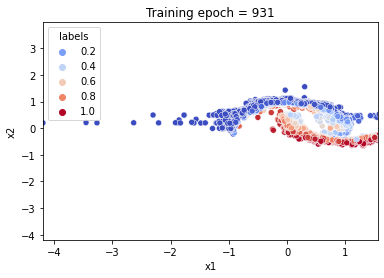

Epoch = 931 	 Loss = -80.514 	 Val loss = 719.172


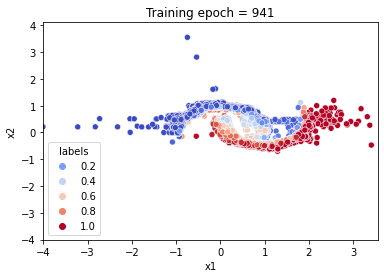

Epoch = 941 	 Loss = -95.754 	 Val loss = 718.722


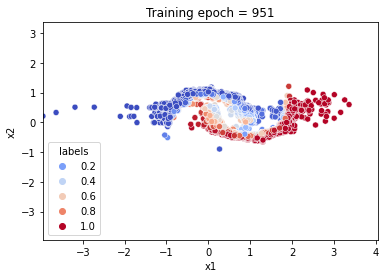

Epoch = 951 	 Loss = -98.494 	 Val loss = nan


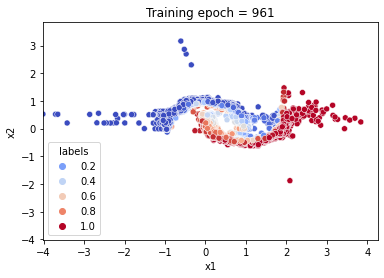

Epoch = 961 	 Loss = -99.830 	 Val loss = 718.787


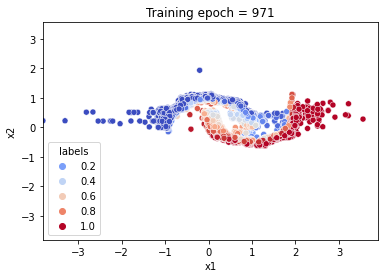

Epoch = 971 	 Loss = -78.054 	 Val loss = 725.521


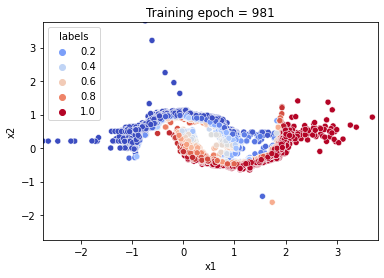

Epoch = 981 	 Loss = -88.963 	 Val loss = 721.593


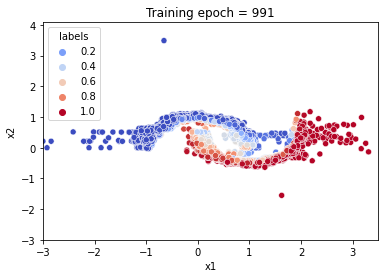

Epoch = 991 	 Loss = -106.771 	 Val loss = 723.016


In [24]:
# we define a suitable metric
accuracy = metrics.BinaryAccuracy()

def update_accuracy():
    """
    util function to update the binary accuracy metric
    to evaluate the algorithm performances.
    """
    accuracy.reset_state()
    y_true = test_dict[0]['labels']
    y_pred, y_var, grad = diglm(test_dict[0]['features'])
    accuracy.update_state(y_true, y_pred.numpy())
    history['accuracy'].append(accuracy.result().numpy())

# hyper parameters
LR = 1e-3
NUM_EPOCHS = 1000
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
val_loss = 0
history = {'accuracy': [], 'train_loss': [], 'val_loss': []}
fig_list = []

weight = 100

update_accuracy()
print(accuracy.result().numpy())

# training loop on epochs
for epoch in range(NUM_EPOCHS):
    #if epoch == int(NUM_EPOCHS / 2):
    #  weight = 0.5
    if epoch % 10 == 0:
      # plot
      name = f'fig{epoch}.jpeg'
      fig_list.append(name)
      plot(name, counter=(epoch + 1))
      plt.show()
      plt.close()
      print(f'Epoch = {epoch+1} \t Loss = {loss:.3f} \t Val loss = {val_loss:.3f}')
    # train batch per batch
    for train_batch, val_batch in zip(train_dict, val_dict):
        loss = train_step(optimizer, train_batch, weight=weight)
        # validation loss
        val_loss = -tf.reduce_mean(diglm.weighted_log_prob(val_batch, scaling_const=weight))
        # updating loss and accuracy
        update_accuracy()
        history['train_loss'].append(loss)
        history['val_loss'].append(val_loss)


## 6. Results

To illustrate the results of the training, we plot:

1. a gif illustrating how the algorithm learnt both to reproduce the feature distribution and the response
2. The loss and accuracy history


In [ ]:
from plot_utils import make_gif


make_gif(fig_list, "diglm_example.gif", duration=0.3)

[![SegmentLocal](diglm/diglm_example.gif 'segment')]

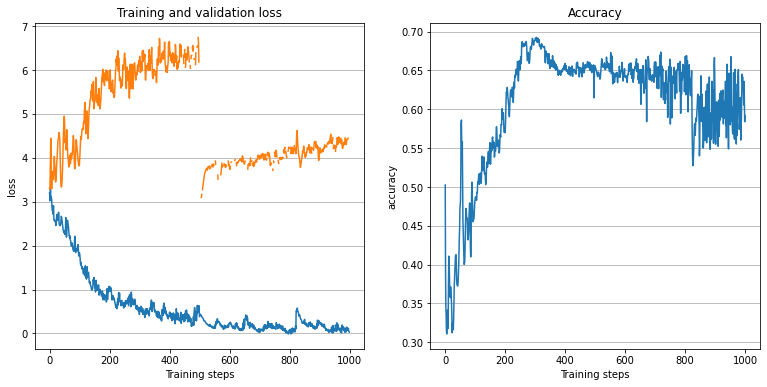

In [22]:
# loss plot
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.title('Training and validation loss')
plt.plot([i for i in range(len(history['train_loss'])-1)],
        history['train_loss'][1:],
        label='train loss')
plt.plot([i for i in range(len(history['val_loss'])-1)],
        history['val_loss'][1:],
        label='val loss')
plt.xlabel('Training steps')
plt.ylabel('loss')
plt.grid(axis='y')

# accuracy plot
plt.subplot(122)
plt.title('Accuracy')
plt.plot([i for i in range(len(history['accuracy']))],
        history['accuracy'])
plt.xlabel('Training steps')
plt.ylabel('accuracy')
plt.grid(axis='y')

Referring to the gif, we see that the algorithm accomplished the task of evaluating the dataset feature distribution as well as the response function. The quality of the response evaluation is monitored through the `BinaryAccuracy` metric, counting the fraction:

\begin{equation}
\dfrac{\text{True Positive + True Negative}}{\text{All}}
\end{equation}

where the Positive / Negative cut on the response function is set to 0.5. After 25 epochs, the loss function attains a *plateau* and the accuracy is stably around 0.97. 

Just as in the SpQR notebook, we can evaluate the quality of the feature distribution evaluation using a Kolmogorov-Smirnov test

In [ ]:
from scipy.stats import ks_2samp


#slicing and preparing arrays to perform the test
mean, x1_trans, x2_trans = sampling(1000)
mean_target, x1_target, x2_target = np.squeeze(np.split(df.to_numpy(), 3, axis=1))

# calculating statistic from K-S test and p-values
stat_1, pval_1 = ks_2samp(x1_trans, x1_target)
stat_2, pval_2 = ks_2samp(x2_trans, x2_target)

print(f'p-value x1 distribution = {pval_1}')
print(f'p-value x2 distribution = {pval_2}')

p-value x1 distribution = 6.26138750958567e-15
p-value x2 distribution = 0.013793921094419213


### About $\lambda$

The hyper-parameter $\lambda$ weights the two component of the log-likelihood loss, favouring the training of one part of the algorithm over the other. Changing this hyper-parameter to 0.5 and 1.0, we saw that the training incurred in overfitting, therefore a reduction of the learning rate was required to obtain good performances.